##Import Library

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2
import torch
from torch import nn
import torchvision
import torch.utils.data as data
import torch.optim as optim
from torch.nn import functional as F
from torch.utils.data import DataLoader
import torchvision.models as models
from torchvision import datasets, transforms
import copy

##Data Transform

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
#transform pipeline
data_transform=transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize((0.485,0.456,0.406),(0.229,0.224,0.225))
])

##Data Loader

In [4]:
Train_path = "/content/drive/MyDrive/Train_data_1"
Valid_path="/content/drive/MyDrive/Valid_data_1"
Test_path = "/content/drive/MyDrive/Test_data (1)"

In [5]:
#data loader
train_data=torchvision.datasets.ImageFolder(root=Train_path,transform=data_transform)
train_data_loader=data.DataLoader(train_data,batch_size=32,shuffle=True,num_workers=2)

valid_data=torchvision.datasets.ImageFolder(root=Valid_path,transform=data_transform)
valid_data_loader=data.DataLoader(valid_data,batch_size=32,shuffle=False,num_workers=2)

test_data=torchvision.datasets.ImageFolder(root=Test_path,transform=data_transform)
test_data_loader=data.DataLoader(test_data,batch_size=2,shuffle=False,num_workers=2)

In [6]:
device=torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

##Load the Resnet model

In [7]:
resnet50=models.resnet50(pretrained=True)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

In [8]:
resnet50.fc=nn.Sequential(
    nn.Linear(2048,128),
    nn.ReLU(inplace=True),
    nn.Linear(128,5)
)
model=resnet50
model.fc

Sequential(
  (0): Linear(in_features=2048, out_features=128, bias=True)
  (1): ReLU(inplace=True)
  (2): Linear(in_features=128, out_features=5, bias=True)
)

In [9]:
model=model.cuda()

##Model Training

In [10]:
from torchvision.transforms.functional import accimage

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
epochs=5
best_acc=0.0
train_loss=[]
val_loss=[]
best_model = copy.deepcopy(model.state_dict())

for epoch in range(epochs):
    print('Epoch {}/{}'.format(epoch+1,epochs))
    print("-"*10)
    training_loss = 0.0
    model.train()
    for inputs, labels in train_data_loader:
        # get the inputs; data is a list of [inputs, labels]=0.0
        inputs, labels = inputs.to(device),labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        training_loss += loss.item()
    train_loss.append(training_loss/len(train_data_loader))

    correct = 0
    total = 0
    valid_loss=0.0
    # since we're not training, we don't need to calculate the gradients for our outputs
    model.eval()
    with torch.no_grad():
        for inputs, labels in valid_data_loader:
            inputs, labels = inputs.to(device),labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            valid_loss+=loss.item()
    
            _, predicted = torch.max(outputs.data, 1)       # the class with the highest energy is what we choose as prediction
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            acc=correct/total
        val_loss.append(valid_loss/len(test_data_loader))

    if(acc>best_acc):
      best_acc=acc
      best_model = copy.deepcopy(model.state_dict())

    print('Train Loss-{}'.format(training_loss/len(train_data)))
    print('Validation Loss-{}'.format(valid_loss/len(test_data)))
    print('Accuracy-{}'.format(acc))
    print("-"*100)
    

print('Best Accuray-{}'.format(best_acc))

Epoch 1/5
----------
Train Loss-0.047961907961734156
Validation Loss-0.47583636045455935
Accuracy-0.8385650224215246
----------------------------------------------------------------------------------------------------
Epoch 2/5
----------
Train Loss-0.03581590897758854
Validation Loss-0.304700031876564
Accuracy-0.9327354260089686
----------------------------------------------------------------------------------------------------
Epoch 3/5
----------
Train Loss-0.019948479076200513
Validation Loss-0.1419920101761818
Accuracy-0.9641255605381166
----------------------------------------------------------------------------------------------------
Epoch 4/5
----------
Train Loss-0.008611607188322285
Validation Loss-0.07476401478052139
Accuracy-0.9775784753363229
----------------------------------------------------------------------------------------------------
Epoch 5/5
----------
Train Loss-0.004416437948984369
Validation Loss-0.04548868797719478
Accuracy-0.9910313901345291
---------------

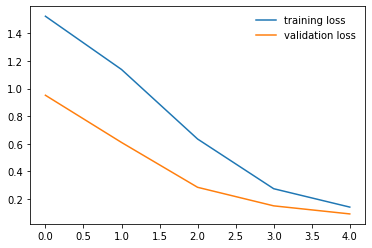

In [11]:
import matplotlib.pyplot as plt
plt.plot(train_loss, label = "training loss")
plt.plot(val_loss, label = "validation loss")
plt.legend(frameon = False)


In [12]:
model.load_state_dict(best_model)

<All keys matched successfully>

In [13]:
torch.save(model.state_dict(),'/content/drive/MyDrive/Image Classification Project/flower_modelnew')

In [14]:
model.load_state_dict(torch.load('/content/drive/MyDrive/Image Classification Project/flower_modelnew',map_location=torch.device('cpu')))

<All keys matched successfully>

In [15]:
model_scripted = torch.jit.script(model) # Export to TorchScript
model_scripted.save('model_scripted500.pt')

In [16]:
!cp -r "/content/model_scripted500.pt" "/content/drive/MyDrive/Image Classification Project"

In [17]:
loaded_model = torch.jit.load('/content/drive/MyDrive/Image Classification Project/model_scripted500.pt')

##Checking for input image

In [18]:
classes=['Hibiscus','Lotus','Other','Rose','Sunflower']
def predict(img):
  imag=data_transform(img)
  inp =imag.unsqueeze(0).cuda()
  outputs=loaded_model(inp)
  pred=F.softmax(outputs[0], dim=0).cpu().data.numpy()
  confidences = {classes[i]:(float(pred[i])) for i in range(5)} 
  return confidences

In [19]:
from PIL import Image
img_path='/content/drive/MyDrive/Test_data (1)/Rose (1)/pexels-photo-1003914 (1).webp'
img=Image.open(img_path)
predict(img)

{'Hibiscus': 0.05101390555500984,
 'Lotus': 0.006132492795586586,
 'Other': 0.008695428259670734,
 'Rose': 0.9254651069641113,
 'Sunflower': 0.008693068288266659}

In [20]:
!pip install gradio

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.3 MB 30.8 MB/s 
     |████████████████████████████████| 54 kB 3.7 MB/s 
     |████████████████████████████████| 84 kB 4.1 MB/s 
     |████████████████████████████████| 56 kB 4.5 MB/s 
     |████████████████████████████████| 270 kB 70.7 MB/s 
     |████████████████████████████████| 55 kB 4.1 MB/s 
     |████████████████████████████████| 84 kB 3.7 MB/s 
     |████████████████████████████████| 212 kB 60.3 MB/s 
     |████████████████████████████████| 112 kB 68.6 MB/s 
     |████████████████████████████████| 2.3 MB 57.6 MB/s 
     |████████████████████████████████| 63 kB 2.5 MB/s 
     |████████████████████████████████| 80 kB 10.7 MB/s 
     |████████████████████████████████| 68 kB 7.7 MB/s 
     |████████████████████████████████| 46 kB 4.0 MB/s 
     |████████████████████████████████| 856 kB 56.4 MB/s 
     |████████████████████████████████| 593 kB 6

In [21]:
import gradio as gr

In [23]:
data_transform1=transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize((0.485,0.456,0.406),(0.229,0.224,0.225))
])

classes=['Hibiscus','Lotus','Rose','Sunflower','None']
def predict(img):
  imag=data_transform1(img)
  inp =imag.unsqueeze(0).cuda()
  outputs=loaded_model(inp)
  pred=F.softmax(outputs[0], dim=0).cpu().data.numpy()
  confidences = {classes[i]:(float(pred[i])) for i in range(5)}    
  return confidences

gr.Interface(predict,gr.inputs.Image(type='pil'),outputs='label').launch(debug=True)

/usr/local/lib/python3.7/dist-packages/gradio/inputs.py:257: UserWarning: Usage of gradio.inputs is deprecated, and will not be supported in the future, please import your component from gradio.components
  "Usage of gradio.inputs is deprecated, and will not be supported in the future, please import your component from gradio.components",
/usr/local/lib/python3.7/dist-packages/gradio/deprecation.py:40: UserWarning: `optional` parameter is deprecated, and it has no effect
  warnings.warn(value)


Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
Running on public URL: https://d28fa38de7fd7b41.gradio.app

This share link expires in 72 hours. For free permanent hosting and GPU upgrades (NEW!), check out Spaces: https://huggingface.co/spaces


Keyboard interruption in main thread... closing server.


(<gradio.routes.App at 0x7f64e28d7fd0>,
 'http://127.0.0.1:7860/',
 'https://d28fa38de7fd7b41.gradio.app')